In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, multi_gpu_model, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
data_dir = 'data/'

In [5]:
# train_data = np.load(path.join(data_dir, 'imagenet_6_class_172_train_data.npz'))
# val_data = np.load(path.join(data_dir, 'imagenet_6_class_172_val_data.npz'))

x_train = np.load(path.join(data_dir, 'imagenet_6_class_172_x_train.npy'))
y_train = np.load(path.join(data_dir, 'imagenet_6_class_172_y_train.npy'))
x_val = np.load(path.join(data_dir, 'imagenet_6_class_172_x_val.npy'))
y_val = np.load(path.join(data_dir, 'imagenet_6_class_172_y_val.npy'))
y_list = np.load(path.join(data_dir, 'imagenet_6_class_172_y_list.npy'))

In [6]:
# x_train = train_data['x_data']
# y_train = train_data['y_data']
# x_val = val_data['x_data']
# y_val = val_data['y_data']
x_test = x_val
y_test = y_val
# y_list = val_data['y_list']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_list.shape

((235111, 172, 172, 3),
 (235111,),
 (3183, 172, 172, 3),
 (3183,),
 (3183, 172, 172, 3),
 (3183,),
 (6,))

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = y_val

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((235111, 172, 172, 3),
 (235111, 6),
 (3183, 172, 172, 3),
 (3183, 6),
 (3183, 172, 172, 3),
 (3183, 6))

In [8]:
input_shape = x_train[0].shape
output_size = len(y_list)

# input_shape = (172,172,3)
# output_size = 6

In [9]:
def build_2d_cnn_custom_ch_64_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**(i//2)), strides=(1,1), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [10]:
for i in range(1, 8):
    model = build_2d_cnn_custom_ch_64_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 172, 172, 64)      4864      
_________________________________________________________________
activation (Activation)      (None, 172, 172, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 86, 86, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 473344)            0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 172, 172, 64)      4864      
_________________________________________________________________
activation_15 (Activation)   (None, 172, 172, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 86, 86, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 86, 86, 64)        102464    
_________________________________________________________________
activation_16 (Activation)   (None, 86, 86, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 43, 43, 64)        0         
__________

In [11]:
class BalanceDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sample_size = int(np.sum(y_data, axis=0).min())
        self.data_shape = x_data.shape[1:]
        self.y_label = self.y_data.argmax(axis=1)
        self.labels = np.unique(self.y_label)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.labels) * self.sample_size / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.zeros((len(self.labels), self.sample_size))
        for i, label in enumerate(self.labels):
            y_index = np.argwhere(self.y_label==label).squeeze()
            if self.shuffle == True:
                self.indexes[i] = np.random.choice(y_index, 
                                   self.sample_size, 
                                   replace=False)
            else:
                self.indexes[i] = y_index[:self.sample_size]
                
        self.indexes = self.indexes.flatten().astype(np.int32)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                
    def __getitem__(self, batch_idx):
        indices = self.indexes[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size]
        return self.x_data[indices], self.y_data[indices]    

In [12]:
batch_size = 40
data_generator = BalanceDataGenerator(x_train, y_train,
                                      batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 1.3368 - acc: 0.4425

Epoch 00001: val_loss improved from inf to 1.33683, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv_checkpoint/001-1.3368.hdf5
242/242 [==============================] - 74s 305ms/step - loss: 1.4728 - acc: 0.3866 - val_loss: 1.3368 - val_acc: 0.4425
Epoch 2/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 1.1710 - acc: 0.5825

Epoch 00002: val_loss improved from 1.33683 to 1.17098, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv_checkpoint/002-1.1710.hdf5
242/242 [==============================] - 57s 237ms/step - loss: 1.2141 - acc: 0.5154 - val_loss: 1.1710 - val_acc: 0.5825
Epoch 3/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 1.2453 - acc: 0.5066

Epoch 00003: val_loss did not improve from 1.170

3200/3183 [==============================] - 28s 9ms/sample - loss: 0.6894 - acc: 0.7375

Epoch 00014: val_loss did not improve from 0.58493
242/242 [==============================] - 60s 248ms/step - loss: 0.6138 - acc: 0.7651 - val_loss: 0.6894 - val_acc: 0.7375
Epoch 15/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.5925 - acc: 0.7912

Epoch 00015: val_loss did not improve from 0.58493
242/242 [==============================] - 55s 228ms/step - loss: 0.6004 - acc: 0.7770 - val_loss: 0.5925 - val_acc: 0.7912
Epoch 16/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.4378 - acc: 0.8637

Epoch 00016: val_loss improved from 0.58493 to 0.43779, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv_checkpoint/016-0.4378.hdf5
242/242 [==============================] - 48s 200ms/step - loss: 0.5859 - acc: 0.7768 - val_loss: 0.4378 - val_acc: 0.8637
Epoch 17/10000
3200/3183 [==========================

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.5852 - acc: 0.7853

Epoch 00029: val_loss did not improve from 0.41601
242/242 [==============================] - 48s 199ms/step - loss: 0.4192 - acc: 0.8419 - val_loss: 0.5852 - val_acc: 0.7853
Epoch 30/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.4417 - acc: 0.8475

Epoch 00030: val_loss did not improve from 0.41601
242/242 [==============================] - 53s 219ms/step - loss: 0.4125 - acc: 0.8451 - val_loss: 0.4417 - val_acc: 0.8475
Epoch 31/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.4874 - acc: 0.8400

Epoch 00031: val_loss did not improve from 0.41601
242/242 [==============================] - 58s 238ms/step - loss: 0.4049 - acc: 0.8498 - val_loss: 0.4874 - val_acc: 0.8400
Epoch 32/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.5916 - acc: 0.7713

Epoch 00032: val_loss did not improve from 0.41601
242/242 [==========

3200/3183 [==============================] - 21s 7ms/sample - loss: 0.3553 - acc: 0.8753

Epoch 00044: val_loss did not improve from 0.32220
242/242 [==============================] - 55s 227ms/step - loss: 0.3125 - acc: 0.8828 - val_loss: 0.3553 - val_acc: 0.8753
Epoch 45/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.3065 - acc: 0.8913

Epoch 00045: val_loss improved from 0.32220 to 0.30650, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv_checkpoint/045-0.3065.hdf5
242/242 [==============================] - 54s 222ms/step - loss: 0.3100 - acc: 0.8856 - val_loss: 0.3065 - val_acc: 0.8913
Epoch 46/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.4516 - acc: 0.8491

Epoch 00046: val_loss did not improve from 0.30650
242/242 [==============================] - 60s 247ms/step - loss: 0.3030 - acc: 0.8888 - val_loss: 0.4516 - val_acc: 0.8491
Epoch 47/10000
3200/3183 [==========================

3200/3183 [==============================] - 30s 9ms/sample - loss: 0.3988 - acc: 0.8675

Epoch 00059: val_loss did not improve from 0.20366
242/242 [==============================] - 71s 293ms/step - loss: 0.2490 - acc: 0.9112 - val_loss: 0.3988 - val_acc: 0.8675
Epoch 60/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.3201 - acc: 0.8900

Epoch 00060: val_loss did not improve from 0.20366
242/242 [==============================] - 52s 216ms/step - loss: 0.2518 - acc: 0.9102 - val_loss: 0.3201 - val_acc: 0.8900
Epoch 61/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.4585 - acc: 0.8381

Epoch 00061: val_loss did not improve from 0.20366
242/242 [==============================] - 57s 237ms/step - loss: 0.2383 - acc: 0.9119 - val_loss: 0.4585 - val_acc: 0.8381
Epoch 62/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.3814 - acc: 0.8625

Epoch 00062: val_loss did not improve from 0.20366
242/242 [==========

3200/3183 [==============================] - 25s 8ms/sample - loss: 0.3066 - acc: 0.9150

Epoch 00074: val_loss did not improve from 0.20264
242/242 [==============================] - 59s 245ms/step - loss: 0.2024 - acc: 0.9290 - val_loss: 0.3066 - val_acc: 0.9150
Epoch 75/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2908 - acc: 0.9081

Epoch 00075: val_loss did not improve from 0.20264
242/242 [==============================] - 59s 245ms/step - loss: 0.2028 - acc: 0.9272 - val_loss: 0.2908 - val_acc: 0.9081
Epoch 76/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.2233 - acc: 0.9275

Epoch 00076: val_loss did not improve from 0.20264
242/242 [==============================] - 56s 233ms/step - loss: 0.2141 - acc: 0.9251 - val_loss: 0.2233 - val_acc: 0.9275
Epoch 77/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2685 - acc: 0.9150

Epoch 00077: val_loss did not improve from 0.20264
242/242 [==========

Epoch 90/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.2348 - acc: 0.9250

Epoch 00090: val_loss did not improve from 0.20264
242/242 [==============================] - 55s 228ms/step - loss: 0.1705 - acc: 0.9388 - val_loss: 0.2348 - val_acc: 0.9250
Epoch 91/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.3486 - acc: 0.8678

Epoch 00091: val_loss did not improve from 0.20264
242/242 [==============================] - 59s 243ms/step - loss: 0.1872 - acc: 0.9331 - val_loss: 0.3486 - val_acc: 0.8678
Epoch 92/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2555 - acc: 0.9159

Epoch 00092: val_loss did not improve from 0.20264
242/242 [==============================] - 61s 252ms/step - loss: 0.1650 - acc: 0.9402 - val_loss: 0.2555 - val_acc: 0.9159
Epoch 93/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2180 - acc: 0.9200

Epoch 00093: val_loss did not improve from 0.20264
242/

Epoch 105/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.3569 - acc: 0.8825

Epoch 00105: val_loss did not improve from 0.16460
242/242 [==============================] - 62s 254ms/step - loss: 0.1588 - acc: 0.9412 - val_loss: 0.3569 - val_acc: 0.8825
Epoch 106/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.3239 - acc: 0.8925

Epoch 00106: val_loss did not improve from 0.16460
242/242 [==============================] - 47s 196ms/step - loss: 0.1581 - acc: 0.9441 - val_loss: 0.3239 - val_acc: 0.8925
Epoch 107/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2804 - acc: 0.9250

Epoch 00107: val_loss did not improve from 0.16460
242/242 [==============================] - 52s 217ms/step - loss: 0.1450 - acc: 0.9499 - val_loss: 0.2804 - val_acc: 0.9250
Epoch 108/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.2321 - acc: 0.9287

Epoch 00108: val_loss did not improve from 0.16460


3200/3183 [==============================] - 18s 6ms/sample - loss: 0.3442 - acc: 0.8800

Epoch 00120: val_loss did not improve from 0.15832
242/242 [==============================] - 66s 274ms/step - loss: 0.1353 - acc: 0.9534 - val_loss: 0.3442 - val_acc: 0.8800
Epoch 121/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1990 - acc: 0.9216

Epoch 00121: val_loss did not improve from 0.15832
242/242 [==============================] - 64s 263ms/step - loss: 0.1423 - acc: 0.9518 - val_loss: 0.1990 - val_acc: 0.9216
Epoch 122/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2933 - acc: 0.9081

Epoch 00122: val_loss did not improve from 0.15832
242/242 [==============================] - 54s 221ms/step - loss: 0.1377 - acc: 0.9494 - val_loss: 0.2933 - val_acc: 0.9081
Epoch 123/10000
3200/3183 [==============================] - 24s 7ms/sample - loss: 0.2280 - acc: 0.9366

Epoch 00123: val_loss did not improve from 0.15832
242/242 [=======

3200/3183 [==============================] - 24s 8ms/sample - loss: 0.1864 - acc: 0.9475

Epoch 00135: val_loss did not improve from 0.13628
242/242 [==============================] - 54s 222ms/step - loss: 0.1269 - acc: 0.9569 - val_loss: 0.1864 - val_acc: 0.9475
Epoch 136/10000
3200/3183 [==============================] - 29s 9ms/sample - loss: 0.2845 - acc: 0.9025

Epoch 00136: val_loss did not improve from 0.13628
242/242 [==============================] - 59s 245ms/step - loss: 0.1311 - acc: 0.9548 - val_loss: 0.2845 - val_acc: 0.9025
Epoch 137/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.2725 - acc: 0.90500s - loss: 0.2744 - acc: 0.904

Epoch 00137: val_loss did not improve from 0.13628
242/242 [==============================] - 63s 259ms/step - loss: 0.1216 - acc: 0.9563 - val_loss: 0.2725 - val_acc: 0.9050
Epoch 138/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.1672 - acc: 0.9500

Epoch 00138: val_loss did not improve

Epoch 151/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.1658 - acc: 0.9350

Epoch 00151: val_loss did not improve from 0.13628
242/242 [==============================] - 59s 245ms/step - loss: 0.1111 - acc: 0.9630 - val_loss: 0.1658 - val_acc: 0.9350
Epoch 152/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.1719 - acc: 0.9394

Epoch 00152: val_loss did not improve from 0.13628
242/242 [==============================] - 56s 233ms/step - loss: 0.1078 - acc: 0.9640 - val_loss: 0.1719 - val_acc: 0.9394
Epoch 153/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.1380 - acc: 0.9575

Epoch 00153: val_loss did not improve from 0.13628
242/242 [==============================] - 60s 248ms/step - loss: 0.1034 - acc: 0.9643 - val_loss: 0.1380 - val_acc: 0.9575
Epoch 154/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2125 - acc: 0.9425

Epoch 00154: val_loss did not improve from 0.13628


3200/3183 [==============================] - 24s 7ms/sample - loss: 0.1843 - acc: 0.9425

Epoch 00166: val_loss did not improve from 0.11836
242/242 [==============================] - 65s 267ms/step - loss: 0.1039 - acc: 0.9639 - val_loss: 0.1843 - val_acc: 0.9425
Epoch 167/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2321 - acc: 0.9244

Epoch 00167: val_loss did not improve from 0.11836
242/242 [==============================] - 56s 230ms/step - loss: 0.1053 - acc: 0.9638 - val_loss: 0.2321 - val_acc: 0.9244
Epoch 168/10000
3200/3183 [==============================] - 27s 9ms/sample - loss: 0.2274 - acc: 0.9175

Epoch 00168: val_loss did not improve from 0.11836
242/242 [==============================] - 61s 254ms/step - loss: 0.0983 - acc: 0.9643 - val_loss: 0.2274 - val_acc: 0.9175
Epoch 169/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.2349 - acc: 0.9250

Epoch 00169: val_loss did not improve from 0.11836
242/242 [=======

Epoch 182/10000
3200/3183 [==============================] - 30s 9ms/sample - loss: 0.1938 - acc: 0.9325

Epoch 00182: val_loss did not improve from 0.11836
242/242 [==============================] - 64s 266ms/step - loss: 0.1019 - acc: 0.9643 - val_loss: 0.1938 - val_acc: 0.9325
Epoch 183/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1635 - acc: 0.9447

Epoch 00183: val_loss did not improve from 0.11836
242/242 [==============================] - 58s 240ms/step - loss: 0.0994 - acc: 0.9657 - val_loss: 0.1635 - val_acc: 0.9447
Epoch 184/10000
3200/3183 [==============================] - 30s 9ms/sample - loss: 0.2136 - acc: 0.9100

Epoch 00184: val_loss did not improve from 0.11836
242/242 [==============================] - 69s 284ms/step - loss: 0.0906 - acc: 0.9693 - val_loss: 0.2136 - val_acc: 0.9100
Epoch 185/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.1762 - acc: 0.9375

Epoch 00185: val_loss did not improve from 0.11836


3200/3183 [==============================] - 28s 9ms/sample - loss: 0.2020 - acc: 0.9413

Epoch 00197: val_loss did not improve from 0.11539
242/242 [==============================] - 65s 270ms/step - loss: 0.0922 - acc: 0.9668 - val_loss: 0.2020 - val_acc: 0.9413
Epoch 198/10000
3200/3183 [==============================] - 27s 8ms/sample - loss: 0.2226 - acc: 0.9162

Epoch 00198: val_loss did not improve from 0.11539
242/242 [==============================] - 75s 310ms/step - loss: 0.0878 - acc: 0.9695 - val_loss: 0.2226 - val_acc: 0.9162
Epoch 199/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.2042 - acc: 0.9350

Epoch 00199: val_loss did not improve from 0.11539
242/242 [==============================] - 57s 237ms/step - loss: 0.0805 - acc: 0.9722 - val_loss: 0.2042 - val_acc: 0.9350
Epoch 200/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.2457 - acc: 0.9325

Epoch 00200: val_loss did not improve from 0.11539
242/242 [=======

Epoch 213/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.1883 - acc: 0.9500

Epoch 00213: val_loss did not improve from 0.09615
242/242 [==============================] - 60s 247ms/step - loss: 0.0871 - acc: 0.9701 - val_loss: 0.1883 - val_acc: 0.9500
Epoch 214/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.1692 - acc: 0.9450

Epoch 00214: val_loss did not improve from 0.09615
242/242 [==============================] - 59s 243ms/step - loss: 0.0829 - acc: 0.9700 - val_loss: 0.1692 - val_acc: 0.9450
Epoch 215/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1602 - acc: 0.9500

Epoch 00215: val_loss did not improve from 0.09615
242/242 [==============================] - 54s 221ms/step - loss: 0.0830 - acc: 0.9689 - val_loss: 0.1602 - val_acc: 0.9500
Epoch 216/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.1425 - acc: 0.9525

Epoch 00216: val_loss did not improve from 0.09615


3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1549 - acc: 0.9513

Epoch 00228: val_loss did not improve from 0.09615
242/242 [==============================] - 72s 299ms/step - loss: 0.0783 - acc: 0.9724 - val_loss: 0.1549 - val_acc: 0.9513
Epoch 229/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.1851 - acc: 0.9475

Epoch 00229: val_loss did not improve from 0.09615
242/242 [==============================] - 56s 232ms/step - loss: 0.0804 - acc: 0.9714 - val_loss: 0.1851 - val_acc: 0.9475
Epoch 230/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.1779 - acc: 0.9469

Epoch 00230: val_loss did not improve from 0.09615
242/242 [==============================] - 74s 308ms/step - loss: 0.0811 - acc: 0.9711 - val_loss: 0.1779 - val_acc: 0.9469
Epoch 231/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.1803 - acc: 0.9438

Epoch 00231: val_loss did not improve from 0.09615
242/242 [=======

Epoch 244/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.1264 - acc: 0.9575

Epoch 00244: val_loss did not improve from 0.09615
242/242 [==============================] - 59s 242ms/step - loss: 0.0787 - acc: 0.9732 - val_loss: 0.1264 - val_acc: 0.9575
Epoch 245/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.2258 - acc: 0.9375

Epoch 00245: val_loss did not improve from 0.09615
242/242 [==============================] - 59s 242ms/step - loss: 0.0711 - acc: 0.9737 - val_loss: 0.2258 - val_acc: 0.9375
Epoch 246/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2690 - acc: 0.9028

Epoch 00246: val_loss did not improve from 0.09615
242/242 [==============================] - 58s 241ms/step - loss: 0.0707 - acc: 0.9758 - val_loss: 0.2690 - val_acc: 0.9028
Epoch 247/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2217 - acc: 0.9325

Epoch 00247: val_loss did not improve from 0.09615


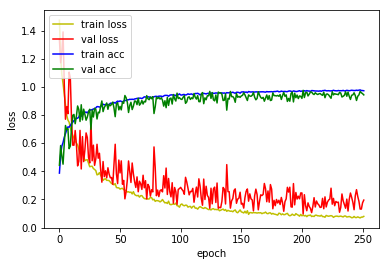

3183/3183 [==============================] - 4s 1ms/sample - loss: 0.1987 - acc: 0.9259
Loss: 0.19873026720746448 Accuracy: 0.9258561

Epoch 1/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 1.6209 - acc: 0.2906

Epoch 00001: val_loss improved from inf to 1.62086, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv_checkpoint/001-1.6209.hdf5
242/242 [==============================] - 60s 250ms/step - loss: 1.4695 - acc: 0.3766 - val_loss: 1.6209 - val_acc: 0.2906
Epoch 2/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 1.0697 - acc: 0.6100

Epoch 00002: val_loss improved from 1.62086 to 1.06971, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv_checkpoint/002-1.0697.hdf5
242/242 [==============================] - 56s 230ms/step - loss: 1.2124 - acc: 0.5145 - val_loss: 1.0697 - val_acc: 0.6100
Epoch 3/10000
3200/3183 [==============================] - 19s 6m

Epoch 15/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.7146 - acc: 0.7362

Epoch 00015: val_loss did not improve from 0.36717
242/242 [==============================] - 55s 228ms/step - loss: 0.5186 - acc: 0.8019 - val_loss: 0.7146 - val_acc: 0.7362
Epoch 16/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.5498 - acc: 0.8075

Epoch 00016: val_loss did not improve from 0.36717
242/242 [==============================] - 54s 224ms/step - loss: 0.4995 - acc: 0.8071 - val_loss: 0.5498 - val_acc: 0.8075
Epoch 17/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.6947 - acc: 0.7572

Epoch 00017: val_loss did not improve from 0.36717
242/242 [==============================] - 55s 229ms/step - loss: 0.4974 - acc: 0.8111 - val_loss: 0.6947 - val_acc: 0.7572
Epoch 18/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.8926 - acc: 0.6756

Epoch 00018: val_loss did not improve from 0.36717
242/

3200/3183 [==============================] - 24s 8ms/sample - loss: 0.2282 - acc: 0.9250

Epoch 00030: val_loss improved from 0.30599 to 0.22822, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv_checkpoint/030-0.2282.hdf5
242/242 [==============================] - 56s 230ms/step - loss: 0.3310 - acc: 0.8770 - val_loss: 0.2282 - val_acc: 0.9250
Epoch 31/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2448 - acc: 0.9075

Epoch 00031: val_loss did not improve from 0.22822
242/242 [==============================] - 51s 212ms/step - loss: 0.3216 - acc: 0.8794 - val_loss: 0.2448 - val_acc: 0.9075
Epoch 32/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.4234 - acc: 0.8350

Epoch 00032: val_loss did not improve from 0.22822
242/242 [==============================] - 54s 222ms/step - loss: 0.3126 - acc: 0.8846 - val_loss: 0.4234 - val_acc: 0.8350
Epoch 33/10000
3200/3183 [==========================

3200/3183 [==============================] - 28s 9ms/sample - loss: 0.4044 - acc: 0.8625

Epoch 00045: val_loss did not improve from 0.22511
242/242 [==============================] - 61s 251ms/step - loss: 0.2216 - acc: 0.9173 - val_loss: 0.4044 - val_acc: 0.8625
Epoch 46/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.5001 - acc: 0.8197

Epoch 00046: val_loss did not improve from 0.22511
242/242 [==============================] - 56s 231ms/step - loss: 0.2326 - acc: 0.9188 - val_loss: 0.5001 - val_acc: 0.8197
Epoch 47/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.4106 - acc: 0.8550

Epoch 00047: val_loss did not improve from 0.22511
242/242 [==============================] - 47s 196ms/step - loss: 0.2355 - acc: 0.9132 - val_loss: 0.4106 - val_acc: 0.8550
Epoch 48/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.2760 - acc: 0.9181

Epoch 00048: val_loss did not improve from 0.22511
242/242 [==========

Epoch 61/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.3004 - acc: 0.8825

Epoch 00061: val_loss did not improve from 0.22297
242/242 [==============================] - 68s 282ms/step - loss: 0.1801 - acc: 0.9364 - val_loss: 0.3004 - val_acc: 0.8825
Epoch 62/10000
3200/3183 [==============================] - 31s 10ms/sample - loss: 0.3282 - acc: 0.8825

Epoch 00062: val_loss did not improve from 0.22297
242/242 [==============================] - 63s 258ms/step - loss: 0.1653 - acc: 0.9455 - val_loss: 0.3282 - val_acc: 0.8825
Epoch 63/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.2758 - acc: 0.9050

Epoch 00063: val_loss did not improve from 0.22297
242/242 [==============================] - 71s 294ms/step - loss: 0.1689 - acc: 0.9398 - val_loss: 0.2758 - val_acc: 0.9050
Epoch 64/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.2857 - acc: 0.8875

Epoch 00064: val_loss did not improve from 0.22297
242

Epoch 76/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1955 - acc: 0.9400

Epoch 00076: val_loss did not improve from 0.14804
242/242 [==============================] - 50s 205ms/step - loss: 0.1509 - acc: 0.9469 - val_loss: 0.1955 - val_acc: 0.9400
Epoch 77/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.4582 - acc: 0.8475

Epoch 00077: val_loss did not improve from 0.14804
242/242 [==============================] - 52s 215ms/step - loss: 0.1340 - acc: 0.9515 - val_loss: 0.4582 - val_acc: 0.8475
Epoch 78/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.3110 - acc: 0.8844

Epoch 00078: val_loss did not improve from 0.14804
242/242 [==============================] - 63s 259ms/step - loss: 0.1394 - acc: 0.9531 - val_loss: 0.3110 - val_acc: 0.8844
Epoch 79/10000
3198/3183 [==============================] - 19s 6ms/sample - loss: 0.2830 - acc: 0.8990

Epoch 00079: val_loss did not improve from 0.14804
242/

3200/3183 [==============================] - 26s 8ms/sample - loss: 0.1794 - acc: 0.9369

Epoch 00091: val_loss did not improve from 0.14308
242/242 [==============================] - 57s 237ms/step - loss: 0.1188 - acc: 0.9561 - val_loss: 0.1794 - val_acc: 0.9369
Epoch 92/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.1512 - acc: 0.9500

Epoch 00092: val_loss did not improve from 0.14308
242/242 [==============================] - 66s 274ms/step - loss: 0.1192 - acc: 0.9568 - val_loss: 0.1512 - val_acc: 0.9500
Epoch 93/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.3582 - acc: 0.8606

Epoch 00093: val_loss did not improve from 0.14308
242/242 [==============================] - 94s 387ms/step - loss: 0.1074 - acc: 0.9615 - val_loss: 0.3582 - val_acc: 0.8606
Epoch 94/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2229 - acc: 0.9303

Epoch 00094: val_loss did not improve from 0.14308
242/242 [==========

Epoch 107/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2235 - acc: 0.9175

Epoch 00107: val_loss did not improve from 0.14308
242/242 [==============================] - 58s 239ms/step - loss: 0.1054 - acc: 0.9624 - val_loss: 0.2235 - val_acc: 0.9175
Epoch 108/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.4264 - acc: 0.8425

Epoch 00108: val_loss did not improve from 0.14308
242/242 [==============================] - 60s 247ms/step - loss: 0.1037 - acc: 0.9627 - val_loss: 0.4264 - val_acc: 0.8425
Epoch 109/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2410 - acc: 0.9041

Epoch 00109: val_loss did not improve from 0.14308
242/242 [==============================] - 56s 232ms/step - loss: 0.1000 - acc: 0.9639 - val_loss: 0.2410 - val_acc: 0.9041
Epoch 110/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.2143 - acc: 0.9128

Epoch 00110: val_loss did not improve from 0.14308


3200/3183 [==============================] - 25s 8ms/sample - loss: 0.2665 - acc: 0.9200

Epoch 00122: val_loss did not improve from 0.11550
242/242 [==============================] - 79s 326ms/step - loss: 0.0922 - acc: 0.9692 - val_loss: 0.2665 - val_acc: 0.9200
Epoch 123/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.1166 - acc: 0.9634

Epoch 00123: val_loss did not improve from 0.11550
242/242 [==============================] - 56s 233ms/step - loss: 0.0929 - acc: 0.9714 - val_loss: 0.1166 - val_acc: 0.9634
Epoch 124/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.1349 - acc: 0.9650

Epoch 00124: val_loss did not improve from 0.11550
242/242 [==============================] - 51s 210ms/step - loss: 0.0899 - acc: 0.9667 - val_loss: 0.1349 - val_acc: 0.9650
Epoch 125/10000
3200/3183 [==============================] - 31s 10ms/sample - loss: 0.2636 - acc: 0.9150

Epoch 00125: val_loss did not improve from 0.11550
242/242 [======

3200/3183 [==============================] - 13s 4ms/sample - loss: 0.1423 - acc: 0.9563

Epoch 00137: val_loss did not improve from 0.11550
242/242 [==============================] - 48s 199ms/step - loss: 0.0851 - acc: 0.9709 - val_loss: 0.1423 - val_acc: 0.9563
Epoch 138/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.2491 - acc: 0.9031

Epoch 00138: val_loss did not improve from 0.11550
242/242 [==============================] - 47s 196ms/step - loss: 0.0848 - acc: 0.9699 - val_loss: 0.2491 - val_acc: 0.9031
Epoch 139/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.3659 - acc: 0.8800

Epoch 00139: val_loss did not improve from 0.11550
242/242 [==============================] - 47s 196ms/step - loss: 0.0720 - acc: 0.9758 - val_loss: 0.3659 - val_acc: 0.8800
Epoch 140/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2401 - acc: 0.9166

Epoch 00140: val_loss did not improve from 0.11550
242/242 [=======

Epoch 153/10000
3200/3183 [==============================] - 52s 16ms/sample - loss: 0.1155 - acc: 0.9575

Epoch 00153: val_loss improved from 0.11550 to 0.11547, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv_checkpoint/153-0.1155.hdf5
242/242 [==============================] - 78s 324ms/step - loss: 0.0782 - acc: 0.9717 - val_loss: 0.1155 - val_acc: 0.9575
Epoch 154/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.1699 - acc: 0.9459

Epoch 00154: val_loss did not improve from 0.11547
242/242 [==============================] - 68s 282ms/step - loss: 0.0741 - acc: 0.9759 - val_loss: 0.1699 - val_acc: 0.9459
Epoch 155/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0999 - acc: 0.9734

Epoch 00155: val_loss improved from 0.11547 to 0.09993, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv_checkpoint/155-0.0999.hdf5
242/242 [========================

Epoch 168/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1540 - acc: 0.9444

Epoch 00168: val_loss did not improve from 0.09993
242/242 [==============================] - 65s 268ms/step - loss: 0.0635 - acc: 0.9782 - val_loss: 0.1540 - val_acc: 0.9444
Epoch 169/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2407 - acc: 0.9125

Epoch 00169: val_loss did not improve from 0.09993
242/242 [==============================] - 65s 269ms/step - loss: 0.0663 - acc: 0.9743 - val_loss: 0.2407 - val_acc: 0.9125
Epoch 170/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1263 - acc: 0.9600

Epoch 00170: val_loss did not improve from 0.09993
242/242 [==============================] - 65s 269ms/step - loss: 0.0770 - acc: 0.9718 - val_loss: 0.1263 - val_acc: 0.9600
Epoch 171/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1369 - acc: 0.9522

Epoch 00171: val_loss did not improve from 0.09993


3200/3183 [==============================] - 13s 4ms/sample - loss: 0.1275 - acc: 0.9575

Epoch 00183: val_loss did not improve from 0.09993
242/242 [==============================] - 66s 272ms/step - loss: 0.0585 - acc: 0.9797 - val_loss: 0.1275 - val_acc: 0.9575
Epoch 184/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2511 - acc: 0.8900

Epoch 00184: val_loss did not improve from 0.09993
242/242 [==============================] - 62s 258ms/step - loss: 0.0651 - acc: 0.9776 - val_loss: 0.2511 - val_acc: 0.8900
Epoch 185/10000
3200/3183 [==============================] - 48s 15ms/sample - loss: 0.2003 - acc: 0.9275

Epoch 00185: val_loss did not improve from 0.09993
242/242 [==============================] - 66s 272ms/step - loss: 0.0597 - acc: 0.9782 - val_loss: 0.2003 - val_acc: 0.9275
Epoch 186/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.1675 - acc: 0.9341

Epoch 00186: val_loss did not improve from 0.09993
242/242 [======

Epoch 199/10000
3200/3183 [==============================] - 45s 14ms/sample - loss: 0.1549 - acc: 0.9475

Epoch 00199: val_loss did not improve from 0.09993
242/242 [==============================] - 64s 263ms/step - loss: 0.0580 - acc: 0.9787 - val_loss: 0.1549 - val_acc: 0.9475
Epoch 200/10000
3200/3183 [==============================] - 43s 14ms/sample - loss: 0.1715 - acc: 0.9375

Epoch 00200: val_loss did not improve from 0.09993
242/242 [==============================] - 63s 258ms/step - loss: 0.0653 - acc: 0.9783 - val_loss: 0.1715 - val_acc: 0.9375
Epoch 201/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.2185 - acc: 0.9300

Epoch 00201: val_loss did not improve from 0.09993
242/242 [==============================] - 64s 266ms/step - loss: 0.0532 - acc: 0.9816 - val_loss: 0.2185 - val_acc: 0.9300
Epoch 202/10000
3200/3183 [==============================] - 46s 14ms/sample - loss: 0.3246 - acc: 0.9000

Epoch 00202: val_loss did not improve from 0.09

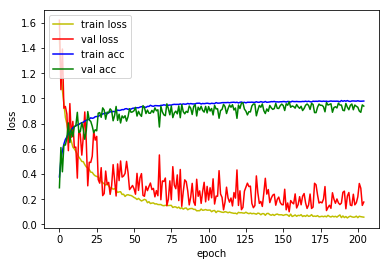

3183/3183 [==============================] - 4s 1ms/sample - loss: 0.2345 - acc: 0.9243
Loss: 0.23450051145549095 Accuracy: 0.9242853

Epoch 1/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 1.4063 - acc: 0.3850

Epoch 00001: val_loss improved from inf to 1.40632, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_7_conv_checkpoint/001-1.4063.hdf5
242/242 [==============================] - 73s 302ms/step - loss: 1.4615 - acc: 0.3778 - val_loss: 1.4063 - val_acc: 0.3850
Epoch 2/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 1.2435 - acc: 0.4875

Epoch 00002: val_loss improved from 1.40632 to 1.24345, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_7_conv_checkpoint/002-1.2435.hdf5
242/242 [==============================] - 72s 298ms/step - loss: 1.1871 - acc: 0.5267 - val_loss: 1.2435 - val_acc: 0.4875
Epoch 3/10000
3200/3183 [==============================] - 51s 16

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.3429 - acc: 0.8838

Epoch 00015: val_loss improved from 0.42582 to 0.34285, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_7_conv_checkpoint/015-0.3429.hdf5
242/242 [==============================] - 70s 287ms/step - loss: 0.4890 - acc: 0.8171 - val_loss: 0.3429 - val_acc: 0.8838
Epoch 16/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.4814 - acc: 0.8334

Epoch 00016: val_loss did not improve from 0.34285
242/242 [==============================] - 70s 290ms/step - loss: 0.4703 - acc: 0.8206 - val_loss: 0.4814 - val_acc: 0.8334
Epoch 17/10000
3200/3183 [==============================] - 43s 14ms/sample - loss: 0.7039 - acc: 0.7378

Epoch 00017: val_loss did not improve from 0.34285
242/242 [==============================] - 64s 266ms/step - loss: 0.4395 - acc: 0.8341 - val_loss: 0.7039 - val_acc: 0.7378
Epoch 18/10000
3200/3183 [========================

Epoch 30/10000
3198/3183 [==============================] - 48s 15ms/sample - loss: 0.6600 - acc: 0.7677

Epoch 00030: val_loss did not improve from 0.30913
242/242 [==============================] - 69s 285ms/step - loss: 0.2875 - acc: 0.8914 - val_loss: 0.6600 - val_acc: 0.7677
Epoch 31/10000
3200/3183 [==============================] - 41s 13ms/sample - loss: 0.6238 - acc: 0.7675

Epoch 00031: val_loss did not improve from 0.30913
242/242 [==============================] - 64s 264ms/step - loss: 0.2777 - acc: 0.8971 - val_loss: 0.6238 - val_acc: 0.7675
Epoch 32/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.3581 - acc: 0.8756

Epoch 00032: val_loss did not improve from 0.30913
242/242 [==============================] - 67s 278ms/step - loss: 0.2674 - acc: 0.9015 - val_loss: 0.3581 - val_acc: 0.8756
Epoch 33/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.3429 - acc: 0.8550

Epoch 00033: val_loss did not improve from 0.30913
24

242/242 [==============================] - 68s 279ms/step - loss: 0.1892 - acc: 0.9305 - val_loss: 0.2266 - val_acc: 0.9200
Epoch 45/10000
3200/3183 [==============================] - 44s 14ms/sample - loss: 0.3378 - acc: 0.8675

Epoch 00045: val_loss did not improve from 0.22660
242/242 [==============================] - 65s 268ms/step - loss: 0.1894 - acc: 0.9312 - val_loss: 0.3378 - val_acc: 0.8675
Epoch 46/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.3283 - acc: 0.8925

Epoch 00046: val_loss did not improve from 0.22660
242/242 [==============================] - 68s 281ms/step - loss: 0.1827 - acc: 0.9316 - val_loss: 0.3283 - val_acc: 0.8925
Epoch 47/10000
3200/3183 [==============================] - 51s 16ms/sample - loss: 0.4947 - acc: 0.8022

Epoch 00047: val_loss did not improve from 0.22660
242/242 [==============================] - 73s 300ms/step - loss: 0.1824 - acc: 0.9344 - val_loss: 0.4947 - val_acc: 0.8022
Epoch 48/10000
3200/3183 [========

Epoch 60/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.4121 - acc: 0.8631

Epoch 00060: val_loss did not improve from 0.17889
242/242 [==============================] - 69s 285ms/step - loss: 0.1472 - acc: 0.9475 - val_loss: 0.4121 - val_acc: 0.8631
Epoch 61/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2508 - acc: 0.9087

Epoch 00061: val_loss did not improve from 0.17889
242/242 [==============================] - 64s 265ms/step - loss: 0.1234 - acc: 0.9553 - val_loss: 0.2508 - val_acc: 0.9087
Epoch 62/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.1641 - acc: 0.9475

Epoch 00062: val_loss improved from 0.17889 to 0.16414, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_7_conv_checkpoint/062-0.1641.hdf5
242/242 [==============================] - 71s 293ms/step - loss: 0.1309 - acc: 0.9538 - val_loss: 0.1641 - val_acc: 0.9475
Epoch 63/10000
3200/3183 [==========

Epoch 75/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.1312 - acc: 0.9569

Epoch 00075: val_loss improved from 0.14113 to 0.13118, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_7_conv_checkpoint/075-0.1312.hdf5
242/242 [==============================] - 70s 288ms/step - loss: 0.1054 - acc: 0.9623 - val_loss: 0.1312 - val_acc: 0.9569
Epoch 76/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.1911 - acc: 0.9347

Epoch 00076: val_loss did not improve from 0.13118
242/242 [==============================] - 66s 272ms/step - loss: 0.1046 - acc: 0.9623 - val_loss: 0.1911 - val_acc: 0.9347
Epoch 77/10000
3200/3183 [==============================] - 40s 12ms/sample - loss: 0.4122 - acc: 0.8575

Epoch 00077: val_loss did not improve from 0.13118
242/242 [==============================] - 63s 258ms/step - loss: 0.1109 - acc: 0.9629 - val_loss: 0.4122 - val_acc: 0.8575
Epoch 78/10000
3200/3183 [=========

3200/3183 [==============================] - 47s 15ms/sample - loss: 0.2352 - acc: 0.9306

Epoch 00090: val_loss did not improve from 0.13118
242/242 [==============================] - 69s 285ms/step - loss: 0.0871 - acc: 0.9683 - val_loss: 0.2352 - val_acc: 0.9306
Epoch 91/10000
3200/3183 [==============================] - 51s 16ms/sample - loss: 0.4512 - acc: 0.8575

Epoch 00091: val_loss did not improve from 0.13118
242/242 [==============================] - 72s 296ms/step - loss: 0.0919 - acc: 0.9681 - val_loss: 0.4512 - val_acc: 0.8575
Epoch 92/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2064 - acc: 0.9475

Epoch 00092: val_loss did not improve from 0.13118
242/242 [==============================] - 70s 288ms/step - loss: 0.0884 - acc: 0.9699 - val_loss: 0.2064 - val_acc: 0.9475
Epoch 93/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2742 - acc: 0.9300

Epoch 00093: val_loss did not improve from 0.13118
242/242 [========

Epoch 106/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2031 - acc: 0.9413

Epoch 00106: val_loss did not improve from 0.13118
242/242 [==============================] - 67s 277ms/step - loss: 0.0805 - acc: 0.9730 - val_loss: 0.2031 - val_acc: 0.9413
Epoch 107/10000
3200/3183 [==============================] - 45s 14ms/sample - loss: 0.2712 - acc: 0.9150

Epoch 00107: val_loss did not improve from 0.13118
242/242 [==============================] - 66s 272ms/step - loss: 0.0754 - acc: 0.9749 - val_loss: 0.2712 - val_acc: 0.9150
Epoch 108/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2553 - acc: 0.9450

Epoch 00108: val_loss did not improve from 0.13118
242/242 [==============================] - 65s 270ms/step - loss: 0.0704 - acc: 0.9759 - val_loss: 0.2553 - val_acc: 0.9450
Epoch 109/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.3138 - acc: 0.9022

Epoch 00109: val_loss did not improve from 0.1311

3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1433 - acc: 0.9575

Epoch 00121: val_loss did not improve from 0.12357
242/242 [==============================] - 72s 297ms/step - loss: 0.0647 - acc: 0.9774 - val_loss: 0.1433 - val_acc: 0.9575
Epoch 122/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.2140 - acc: 0.9200

Epoch 00122: val_loss did not improve from 0.12357
242/242 [==============================] - 69s 286ms/step - loss: 0.0752 - acc: 0.9752 - val_loss: 0.2140 - val_acc: 0.9200
Epoch 123/10000
3200/3183 [==============================] - 48s 15ms/sample - loss: 0.1833 - acc: 0.9391

Epoch 00123: val_loss did not improve from 0.12357
242/242 [==============================] - 71s 295ms/step - loss: 0.0716 - acc: 0.9760 - val_loss: 0.1833 - val_acc: 0.9391
Epoch 124/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.1741 - acc: 0.9506

Epoch 00124: val_loss did not improve from 0.12357
242/242 [======

Epoch 136/10000
3200/3183 [==============================] - 50s 16ms/sample - loss: 0.1540 - acc: 0.9522

Epoch 00136: val_loss did not improve from 0.10482
242/242 [==============================] - 73s 303ms/step - loss: 0.0708 - acc: 0.9741 - val_loss: 0.1540 - val_acc: 0.9522
Epoch 137/10000
3200/3183 [==============================] - 43s 13ms/sample - loss: 0.1793 - acc: 0.9359

Epoch 00137: val_loss did not improve from 0.10482
242/242 [==============================] - 66s 275ms/step - loss: 0.0630 - acc: 0.9781 - val_loss: 0.1793 - val_acc: 0.9359
Epoch 138/10000
3200/3183 [==============================] - 45s 14ms/sample - loss: 0.1684 - acc: 0.9394

Epoch 00138: val_loss did not improve from 0.10482
242/242 [==============================] - 66s 274ms/step - loss: 0.0596 - acc: 0.9802 - val_loss: 0.1684 - val_acc: 0.9394
Epoch 139/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.1531 - acc: 0.9500

Epoch 00139: val_loss did not improve from 0.10

3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1719 - acc: 0.9525

Epoch 00151: val_loss did not improve from 0.08952
242/242 [==============================] - 67s 276ms/step - loss: 0.0633 - acc: 0.9769 - val_loss: 0.1719 - val_acc: 0.9525
Epoch 152/10000
3200/3183 [==============================] - 49s 15ms/sample - loss: 0.2848 - acc: 0.9206

Epoch 00152: val_loss did not improve from 0.08952
242/242 [==============================] - 70s 291ms/step - loss: 0.0567 - acc: 0.9800 - val_loss: 0.2848 - val_acc: 0.9206
Epoch 153/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.1093 - acc: 0.9594

Epoch 00153: val_loss did not improve from 0.08952
242/242 [==============================] - 66s 272ms/step - loss: 0.0560 - acc: 0.9807 - val_loss: 0.1093 - val_acc: 0.9594
Epoch 154/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2131 - acc: 0.9306

Epoch 00154: val_loss did not improve from 0.08952
242/242 [======

3200/3183 [==============================] - 46s 14ms/sample - loss: 0.1436 - acc: 0.9575

Epoch 00166: val_loss did not improve from 0.07387
242/242 [==============================] - 68s 282ms/step - loss: 0.0571 - acc: 0.9802 - val_loss: 0.1436 - val_acc: 0.9575
Epoch 167/10000
3200/3183 [==============================] - 45s 14ms/sample - loss: 0.1524 - acc: 0.9563

Epoch 00167: val_loss did not improve from 0.07387
242/242 [==============================] - 68s 280ms/step - loss: 0.0546 - acc: 0.9796 - val_loss: 0.1524 - val_acc: 0.9563
Epoch 168/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2655 - acc: 0.9200

Epoch 00168: val_loss did not improve from 0.07387
242/242 [==============================] - 75s 311ms/step - loss: 0.0513 - acc: 0.9820 - val_loss: 0.2655 - val_acc: 0.9200
Epoch 169/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0935 - acc: 0.9700

Epoch 00169: val_loss did not improve from 0.07387
242/242 [=====

Epoch 182/10000
3200/3183 [==============================] - 48s 15ms/sample - loss: 0.2592 - acc: 0.9234

Epoch 00182: val_loss did not improve from 0.07387
242/242 [==============================] - 76s 313ms/step - loss: 0.0534 - acc: 0.9810 - val_loss: 0.2592 - val_acc: 0.9234
Epoch 183/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.1860 - acc: 0.9131

Epoch 00183: val_loss did not improve from 0.07387
242/242 [==============================] - 79s 327ms/step - loss: 0.0555 - acc: 0.9797 - val_loss: 0.1860 - val_acc: 0.9131
Epoch 184/10000
3200/3183 [==============================] - 52s 16ms/sample - loss: 0.2356 - acc: 0.9200

Epoch 00184: val_loss did not improve from 0.07387
242/242 [==============================] - 73s 302ms/step - loss: 0.0521 - acc: 0.9808 - val_loss: 0.2356 - val_acc: 0.9200
Epoch 185/10000
3200/3183 [==============================] - 53s 16ms/sample - loss: 0.1395 - acc: 0.9475

Epoch 00185: val_loss did not improve from 0.073

3200/3183 [==============================] - 20s 6ms/sample - loss: 0.1904 - acc: 0.9456

Epoch 00197: val_loss did not improve from 0.07135
242/242 [==============================] - 76s 314ms/step - loss: 0.0418 - acc: 0.9856 - val_loss: 0.1904 - val_acc: 0.9456
Epoch 198/10000
3200/3183 [==============================] - 52s 16ms/sample - loss: 0.2488 - acc: 0.9200

Epoch 00198: val_loss did not improve from 0.07135
242/242 [==============================] - 74s 307ms/step - loss: 0.0492 - acc: 0.9836 - val_loss: 0.2488 - val_acc: 0.9200
Epoch 199/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.2228 - acc: 0.9419

Epoch 00199: val_loss did not improve from 0.07135
242/242 [==============================] - 78s 321ms/step - loss: 0.0453 - acc: 0.9844 - val_loss: 0.2228 - val_acc: 0.9419
Epoch 200/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.2490 - acc: 0.9375

Epoch 00200: val_loss did not improve from 0.07135
242/242 [======

Epoch 213/10000
3200/3183 [==============================] - 54s 17ms/sample - loss: 0.1454 - acc: 0.9491

Epoch 00213: val_loss did not improve from 0.07135
242/242 [==============================] - 87s 358ms/step - loss: 0.0516 - acc: 0.9824 - val_loss: 0.1454 - val_acc: 0.9491
Epoch 214/10000
3200/3183 [==============================] - 51s 16ms/sample - loss: 0.2673 - acc: 0.9150

Epoch 00214: val_loss did not improve from 0.07135
242/242 [==============================] - 80s 330ms/step - loss: 0.0466 - acc: 0.9840 - val_loss: 0.2673 - val_acc: 0.9150
Epoch 215/10000
3200/3183 [==============================] - 49s 15ms/sample - loss: 0.1515 - acc: 0.9431

Epoch 00215: val_loss did not improve from 0.07135
242/242 [==============================] - 77s 318ms/step - loss: 0.0439 - acc: 0.9853 - val_loss: 0.1515 - val_acc: 0.9431
Epoch 216/10000
3200/3183 [==============================] - 54s 17ms/sample - loss: 0.1755 - acc: 0.9463

Epoch 00216: val_loss did not improve from 0.07

3200/3183 [==============================] - 54s 17ms/sample - loss: 0.1574 - acc: 0.9575

Epoch 00228: val_loss did not improve from 0.07135
242/242 [==============================] - 75s 309ms/step - loss: 0.0347 - acc: 0.9890 - val_loss: 0.1574 - val_acc: 0.9575
Epoch 229/10000
3200/3183 [==============================] - 50s 16ms/sample - loss: 0.2151 - acc: 0.9309

Epoch 00229: val_loss did not improve from 0.07135
242/242 [==============================] - 77s 319ms/step - loss: 0.0353 - acc: 0.9891 - val_loss: 0.2151 - val_acc: 0.9309
Epoch 230/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1831 - acc: 0.9500

Epoch 00230: val_loss did not improve from 0.07135
242/242 [==============================] - 77s 320ms/step - loss: 0.0388 - acc: 0.9877 - val_loss: 0.1831 - val_acc: 0.9500
Epoch 231/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2675 - acc: 0.9256

Epoch 00231: val_loss did not improve from 0.07135
242/242 [=====

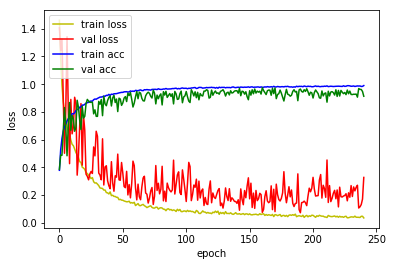

3183/3183 [==============================] - 6s 2ms/sample - loss: 0.2094 - acc: 0.9359
Loss: 0.20936278329750782 Accuracy: 0.9359095



In [13]:
for i in range(5, 8):
    base = 'vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_custom_ch_64_DO(conv_num=i)
#     model = multi_gpu_model(model, gpus=2)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit_generator(data_generator,
            steps_per_epoch=len(x_train)//batch_size,
            epochs=10000,
            validation_data=(x_val, y_val),
            callbacks = [checkpointer, early_stopping],
            workers=8, 
            use_multiprocessing=True
    )

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = 'vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(5, 8):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test, y_test)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 64)      4864      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 64)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 86, 64)        102464    
_________________________________________________________________
activation_29 (Activation)   (None, 86, 86, 64)        0         
_________________________________________________________________
max_pooling

3183/3183 [==============================] - 4s 1ms/sample - loss: 0.2094 - acc: 0.9359
Loss: 0.20936278329750782 Accuracy: 0.9359095


In [15]:
for i in range(5, 8):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 64)      4864      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 64)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 86, 64)        102464    
_________________________________________________________________
activation_29 (Activation)   (None, 86, 86, 64)        0         
_________________________________________________________________
max_pooling

3183/3183 [==============================] - 4s 1ms/sample - loss: 0.2102 - acc: 0.9466
Loss: 0.21024965254886605 Accuracy: 0.94659126


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
i = 6
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)


vis_imagenet_6_class_2D_CNN_custom_ch_64_DO_050_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 172, 172, 64)      4864      
_________________________________________________________________
activation_33 (Activation)   (None, 172, 172, 64)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 86, 86, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 86, 86, 64)        102464    
_________________________________________________________________
activation_34 (Activation)   (None, 86, 86, 64)        0         
_________________________________________________________________
max_pooling

Confusion Matrix
[[  29    1    0    0    0    0]
 [   1 1018    0   22    1    8]
 [   0   10   50   18    0    0]
 [   3  147   18 1770    1    1]
 [   0    1    0    0   32    1]
 [   0    7    0    0    1   43]]

Classification Report
              precision    recall  f1-score   support

         bed       0.88      0.97      0.92        30
        bird       0.86      0.97      0.91      1050
         cat       0.74      0.64      0.68        78
         dog       0.98      0.91      0.94      1940
       house       0.91      0.94      0.93        34
        tree       0.81      0.84      0.83        51

   micro avg       0.92      0.92      0.92      3183
   macro avg       0.86      0.88      0.87      3183
weighted avg       0.93      0.92      0.92      3183




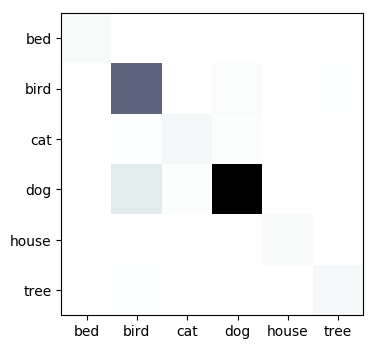

In [22]:
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_real = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_real, y_pred)
print('Confusion Matrix')
print(confusion_mat)
print()

print('Classification Report')
print(classification_report(y_real, y_pred, target_names=y_list))
print()

# labels = y_table.T[0]
plt.figure(figsize=(4,4), dpi=100)
plt.xticks(np.arange(len(y_list)), y_list)
plt.yticks(np.arange(len(y_list)), y_list)
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.bone_r)

In [19]:
y_list

array(['bed', 'bird', 'cat', 'dog', 'house', 'tree'], dtype='<U5')